In [322]:
import random
import gensim
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.decomposition
import sklearn.feature_extraction
from sklearn.linear_model import LinearRegression
import ipywidgets as widgets
import seaborn as sns
from wordcloud import WordCloud
from IPython.display import display
from collections import defaultdict


In [323]:
year = '2024'
data_path = f'/Users/naphat-c/Documents/naphat/Data/project/CEDT-DS-Project_LittleMermaid/Kafka/output_csv/{year}.csv'
df = pd.read_csv(data_path)

In [324]:
df.head()

,Title,Abstract,Author,Aggregation_Type,Publisher,Publication_Date,Institutions,Keywords
0,Embracing innovation and collaboration: A mess...,NaN,Li M.,Journal,Cancer Letters,2024-12-28,University of Oklahoma College of Medicine,NaN
1,Bio-inspiration unveiled: Dissecting nature's ...,Investigating nature's ingenious designs and s...,Ayali A.; Sonnenreich S.; El Pinchasik B.,Journal,iScience,2024-12-20,Tel Aviv University,Biological sciences ; Engineering ; Physics
2,Improving adsorption and purification performa...,Enhancing adsorption ability of photocatalyst ...,Yu X.; Liu M.; Xu H.; Xu J.; Yi J.,Journal,Environmental Pollution,2024-12-15,Wuhan Textile University,Adsorption ; Bi WO /BiOCl heterojunction 2 6 ...
3,Bibliometric insights into palm oil mill efflu...,This analysis explores the research landscape ...,Mohamed Noor M.; Ngadi N.; Ab Hamid N.,Journal,Industrial Crops and Products,2024-12-15,Universiti Teknologi Malaysia,Bibliometric ; Coagulation ; Flocculation ; ...
4,Graphene-encapsulated nanocomposites: Synthesi...,The discovery of graphene and its remarkable p...,Fu H.; Gray K.,Journal,Science of the Total Environment,2024-12-10,Robert R. McCormick School of Engineering and ...,3D graphene material ; Graphene-based nanocom...


In [325]:
df['Publication_Date'] = pd.to_datetime(df['Publication_Date'])
df['Quarter'] = df['Publication_Date'].dt.quarter
quarter_counts = df['Quarter'].value_counts().sort_index()
quarter_counts

Quarter
1    1238
2     376
3     317
4     231
Name: count, dtype: int64

In [326]:
data = {
    "Year": [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024],
    "Q1": [600, 522, 611, 1622, 2023, 2055, 2301, 2562, 2589, 1238],
    "Q2": [75, 200, 192, 757, 773, 908, 1016, 916, 813, 376],
    "Q3": [129, 101, 173, 838, 713, 891, 982, 981, 721, 317],
    "Q4": [145, 150, 175, 776, 986, 1109, 1182, 1236, 561, 231],
}

In [327]:
df = pd.DataFrame(data)

In [328]:
df

,Year,Q1,Q2,Q3,Q4
0,2015,600,75,129,145
1,2016,522,200,101,150
2,2017,611,192,173,175
3,2018,1622,757,838,776
4,2019,2023,773,713,986
5,2020,2055,908,891,1109
6,2021,2301,1016,982,1182
7,2022,2562,916,981,1236
8,2023,2589,813,721,561
9,2024,1238,376,317,231


In [329]:
df_normalized = df.copy()
for year in df["Year"].unique():
    year_data = df[df["Year"] == year]
    total = year_data[["Q1", "Q2", "Q3", "Q4"]].sum(axis=1).values[0]  # คำนวณผลรวมของแต่ละปี
    for quarter in ["Q1", "Q2", "Q3", "Q4"]:
        df_normalized.loc[df_normalized["Year"] == year, quarter] = (
            df_normalized.loc[df_normalized["Year"] == year, quarter] / total * 100
        )   

/var/folders/9d/_94dxqq16tz622b5m4ygxcd40000gn/T/ipykernel_74655/3756294864.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[63.22444679]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_normalized.loc[df_normalized["Year"] == year, quarter] = (
/var/folders/9d/_94dxqq16tz622b5m4ygxcd40000gn/T/ipykernel_74655/3756294864.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[7.90305585]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_normalized.loc[df_normalized["Year"] == year, quarter] = (
/var/folders/9d/_94dxqq16tz622b5m4ygxcd40000gn/T/ipykernel_74655/3756294864.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[13.59325606]' has dtype incompatibl

In [330]:
df_normalized

,Year,Q1,Q2,Q3,Q4
0,2015,63.224447,7.903056,13.593256,15.279241
1,2016,53.648510,20.554985,10.380267,15.416238
2,2017,53.084275,16.681147,15.030408,15.204170
3,2018,40.621087,18.958177,20.986727,19.434010
4,2019,45.005562,17.196885,15.862069,21.935484
5,2020,41.406407,18.295386,17.952851,22.345356
6,2021,41.981390,18.536763,17.916439,21.565408
7,2022,44.986831,16.084284,17.225637,21.703248
8,2023,55.273271,17.356960,15.392827,11.976943
9,2024,57.261795,17.391304,14.662350,10.684551


In [331]:
X = df_normalized["Year"].values.reshape(-1, 1)  # Reshape to fit the model
pred_years = np.array([2025, 2026]).reshape(-1, 1)  # Years to forecast

In [332]:
def predict_quarter(quarter):
    y = df_normalized[quarter].values  # Select the quarter needed
    model = LinearRegression()  # Linear Regression model
    model.fit(X, y)  # Train the model
    predictions = model.predict(pred_years)  # Forecast for years 2025 and 2026
    return predictions

In [333]:
results = {}
for quarter in ["Q1", "Q2", "Q3", "Q4"]:
    predictions = predict_quarter(quarter)
    results[quarter] = {
        "2025": predictions[0],
        "2026": predictions[1],
    }

In [334]:
print("Predicted values for 2025 and 2026:")
for quarter, values in results.items():
    print(f"{quarter}: 2025 -> {values['2025']:.2f}%, 2026 -> {values['2026']:.2f}%")

Predicted values for 2025 and 2026:
Q1: 2025 -> 46.91%, 2026 -> 46.41%
Q2: 2025 -> 18.89%, 2026 -> 19.25%
Q3: 2025 -> 17.52%, 2026 -> 17.81%
Q4: 2025 -> 16.68%, 2026 -> 16.53%


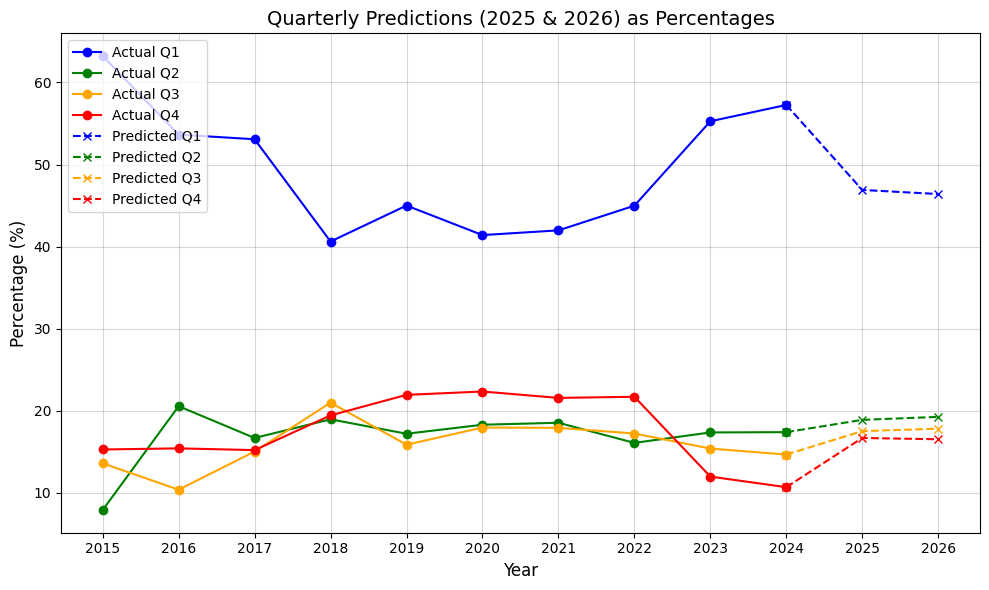

In [335]:
plt.figure(figsize=(10, 6))
colors = ["blue", "green", "orange", "red"]

# Actual data
for i, quarter in enumerate(["Q1", "Q2", "Q3", "Q4"]):
    y = df_normalized[quarter].values
    plt.plot(df_normalized["Year"], y, label=f"Actual {quarter}", color=colors[i], marker="o")

# Predicted data
for i, quarter in enumerate(["Q1", "Q2", "Q3", "Q4"]):
    plt.plot(
        [2024, 2025, 2026],
        [df_normalized[df_normalized["Year"] == 2024][quarter].values[0],
         results[quarter]["2025"], results[quarter]["2026"]],
        label=f"Predicted {quarter}",
        color=colors[i],
        linestyle="--",
        marker="x",
    )

# Adjusting the graph for better readability
plt.xticks(range(2015, 2027), fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Percentage (%)", fontsize=12)
plt.title("Quarterly Predictions (2025 & 2026) as Percentages", fontsize=14)
plt.legend(fontsize=10, loc="upper left")
plt.grid(alpha=0.5)
plt.tight_layout()

plt.show()